<a href="https://colab.research.google.com/github/ostix360/heat_eq/blob/main/heat_eq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

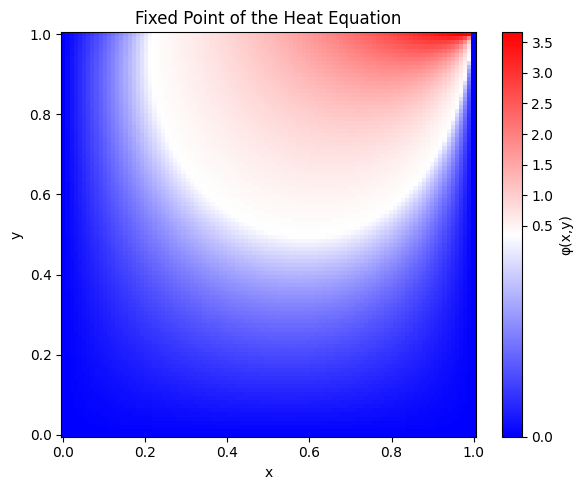

In [11]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, Text, FloatText, IntSlider

# 1. Parse the symbolic border condition theta(x)
def parse_theta_numeric(theta_str, Lx, Ly):
    """
    Convert a string \u03B8(x) into a Python function for numeric evaluation.

    Parameters
    ----------
    theta_str : str
        Boundary expression in x, e.g. 'sin(pi*x/Lx) + 0.5*x'
    Lx, Ly : float
        Domain lengths (needed if referenced in the expression)

    Returns
    -------
    theta_fn : callable
        Vectorized function theta_fn(x_array) -> values
    """
    x = sp.symbols('x')
    Lx_s, Ly_s = sp.symbols('Lx Ly')
    local_dict = {'sin': sp.sin, 'cos': sp.cos, 'exp': sp.exp, 'pi': sp.pi,
                  'Lx': Lx_s, 'Ly': Ly_s}
    expr = sp.sympify(theta_str, locals=local_dict)
    # lambdify to numpy
    theta_fn = sp.lambdify((x, Lx_s, Ly_s), expr, 'numpy')
    return lambda x_vals: theta_fn(x_vals, Lx, Ly)

# 2. Numerically decompose theta on the sinh-sin basis
def decompose_theta_numeric(theta_fn, Lx, Ly, N_terms, N_quad=2000):
    """
    Compute numeric coefficients A_n for n=1..N_terms.

    theta_fn : callable
        Function of x that returns theta(x)
    Lx, Ly : float
    N_terms : int
    N_quad : int
        Number of quadrature points for trapezoidal integration

    Returns
    -------
    coeffs : np.ndarray
        Array of length N_terms of A_n
    lambdas : np.ndarray
        Array of lambda_n values
    """
    xs = np.linspace(0, Lx, N_quad)
    theta_vals = theta_fn(xs)
    coeffs = np.zeros(N_terms)
    lambdas = np.zeros(N_terms)
    for n in range(1, N_terms+1):
        lam = np.pi * n / Lx
        integrand = theta_vals * np.sin(lam * xs)
        integral = np.trapezoid(integrand, xs)
        A_n = (2.0 / Lx) * integral / np.sinh(lam * Ly)
        coeffs[n-1] = A_n
        lambdas[n-1] = lam
    return coeffs, lambdas

# 3. Evaluate phi on a grid using numeric coeffs
def compute_phi_numeric(coeffs, lambdas, Lx, Ly, Nx=100, Ny=100):
    xs = np.linspace(0, Lx, Nx)
    ys = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(xs, ys)
    Phi = np.zeros_like(X)
    for A_n, lam in zip(coeffs, lambdas):
        Phi += A_n * np.sinh(lam * Y) * np.sin(lam * X)
    return X, Y, Phi

# 4. Plot the fixed-point heatmap
def plot_phi(X, Y, Phi, cmap='bwr'):
    plt.figure(figsize=(6,5))
    norm = TwoSlopeNorm(vmin=Phi.min(), vcenter=Phi.mean(), vmax=Phi.max())
    plt.pcolormesh(X, Y, Phi, cmap=cmap, norm=norm, shading='auto')
    plt.colorbar(label='\u03C6(x,y)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Fixed Point of the Heat Equation')
    plt.tight_layout()
    plt.show()

# Example usage in a notebook:
# --------------------------------
# from heat_eq_fixpoint import parse_theta, decompose_theta, compute_phi_numeric, plot_phi
#
Lx, Ly = 1.0, 1.0
theta_str = 'x + 3*x^2'
theta_fn = parse_theta_numeric(theta_str, Lx, Ly)
coeffs, lambdas = decompose_theta_numeric(theta_fn, Lx, Ly, N_terms=200)
X, Y, Phi = compute_phi_numeric(coeffs, lambdas, Lx, Ly)
plot_phi(X, Y, Phi)

In [7]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from ipywidgets import interact, Text, FloatText, IntSlider

# --- Parsing boundary conditions ---

def parse_boundary_x(theta_str, Lx, Ly):
    """
    Parse theta(x) for top/bottom walls.
    """
    x = sp.symbols('x')
    Lx_s, Ly_s = sp.symbols('Lx Ly')
    expr = sp.sympify(theta_str, locals={'sin':sp.sin,'cos':sp.cos,'exp':sp.exp,'pi':sp.pi,'Lx':Lx_s,'Ly':Ly_s})
    fn = sp.lambdify((x, Lx_s, Ly_s), expr, 'numpy')
    return lambda xs: fn(xs, Lx, Ly)


def parse_boundary_y(psi_str, Lx, Ly):
    """
    Parse psi(y) for left/right walls.
    """
    y = sp.symbols('y')
    Lx_s, Ly_s = sp.symbols('Lx Ly')
    expr = sp.sympify(psi_str, locals={'sin':sp.sin,'cos':sp.cos,'exp':sp.exp,'pi':sp.pi,'Lx':Lx_s,'Ly':Ly_s})
    fn = sp.lambdify((y, Lx_s, Ly_s), expr, 'numpy')
    return lambda ys: fn(ys, Lx, Ly)

# --- Decomposition on sine series ---

def decompose_1d(fn_vals, coords, L, N_terms):
    """
    Compute sine-series coefficients A_n for input sampled on coords.
    """
    coeffs = np.zeros(N_terms)
    modes = np.zeros(N_terms)
    for n in range(1, N_terms+1):
        k = n * np.pi / L
        integrand = fn_vals * np.sin(k * coords)
        integral = np.trapezoid(integrand, coords)
        A_n = (2.0 / L) * integral
        coeffs[n-1] = A_n
        modes[n-1] = k
    return coeffs, modes

# --- Harmonic extensions for each wall ---

def phi_top(theta_fn, Lx, Ly, N_terms, Nx=100, Ny=100):
    xs = np.linspace(0, Lx, Nx)
    thetas = theta_fn(xs)
    A, lam = decompose_1d(thetas, xs, Lx, N_terms)
    X,Y = np.meshgrid(xs, np.linspace(0, Ly, Ny))
    Phi = np.zeros_like(X)
    for A_n, k in zip(A, lam):
        Phi += A_n * np.sinh(k * Y) / np.sinh(k * Ly) * np.sin(k * X)
    return X, Y, Phi


def phi_bottom(theta_fn, Lx, Ly, N_terms, Nx=100, Ny=100):
    xs = np.linspace(0, Lx, Nx)
    thetas = theta_fn(xs)
    A, lam = decompose_1d(thetas, xs, Lx, N_terms)
    X,Y = np.meshgrid(xs, np.linspace(0, Ly, Ny))
    Phi = np.zeros_like(X)
    for A_n, k in zip(A, lam):
        Phi += A_n * np.sinh(k * (Ly - Y)) / np.sinh(k * Ly) * np.sin(k * X)
    return X, Y, Phi


def phi_left(psi_fn, Lx, Ly, N_terms, Nx=100, Ny=100):
    ys = np.linspace(0, Ly, Ny)
    psis = psi_fn(ys)
    B, mu = decompose_1d(psis, ys, Ly, N_terms)
    X,Y = np.meshgrid(np.linspace(0, Lx, Nx), ys)
    Phi = np.zeros_like(X)
    for B_m, k in zip(B, mu):
        Phi += B_m * np.sinh(k * X) / np.sinh(k * Lx) * np.sin(k * Y)
    return X, Y, Phi


def phi_right(psi_fn, Lx, Ly, N_terms, Nx=100, Ny=100):
    ys = np.linspace(0, Ly, Ny)
    psis = psi_fn(ys)
    B, mu = decompose_1d(psis, ys, Ly, N_terms)
    X,Y = np.meshgrid(np.linspace(0, Lx, Nx), ys)
    Phi = np.zeros_like(X)
    for B_m, k in zip(B, mu):
        Phi += B_m * np.sinh(k * (Lx - X)) / np.sinh(k * Lx) * np.sin(k * Y)
    return X, Y, Phi

# --- Combine and plot ---

def plot_total(phi_list, cmap='viridis'):
    # assumes all grids identical X,Y
    X,Y = phi_list[0][0], phi_list[0][1]
    Phi_total = sum(p[2] for p in phi_list)
    plt.figure(figsize=(6,5))
    norm = TwoSlopeNorm(vmin=Phi_total.min(), vcenter=Phi_total.mean(), vmax=Phi_total.max())
    plt.pcolormesh(X, Y, Phi_total, cmap=cmap, norm=norm, shading='auto')
    plt.colorbar(label='\u03C6(x,y)')
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('Harmonic Extension of 4 Boundaries')
    plt.tight_layout(); plt.show()

# --- Interactive widget for Colab/Jupyter ---

@interact(
    phi_top_str=Text('0', description='Top y=Ly:'),
    phi_bottom_str=Text('0', description='Bottom y=0:'),
    phi_left_str=Text('0', description='Left x=0:'),
    phi_right_str=Text('0', description='Right x=Lx:'),
    Lx=FloatText(1.0, description='Lx:'),
    Ly=FloatText(1.0, description='Ly:'),
    N_terms=IntSlider(50, min=10, max=200, step=10, description='Modes')
)

def show(phi_top_str, phi_bottom_str, phi_left_str, phi_right_str, Lx, Ly, N_terms):
    # parse
    fn_top = parse_boundary_x(phi_top_str, Lx, Ly)
    fn_bot = parse_boundary_x(phi_bottom_str, Lx, Ly)
    fn_left = parse_boundary_y(phi_left_str, Lx, Ly)
    fn_right = parse_boundary_y(phi_right_str, Lx, Ly)
    # compute
    p_top = phi_top(fn_top, Lx, Ly, N_terms)
    p_bot = phi_bottom(fn_bot, Lx, Ly, N_terms)
    p_left = phi_left(fn_left, Lx, Ly, N_terms)
    p_right = phi_right(fn_right, Lx, Ly, N_terms)
    # plot
    plot_total([p_top, p_bot, p_left, p_right])


interactive(children=(Text(value='0', description='Top y=Ly:'), Text(value='0', description='Bottom y=0:'), Te…

<Figure size 600x500 with 0 Axes>

Error in callback <function _draw_all_if_interactive at 0x7fb3b1f2bd80> (for post_execute):


ValueError: vmin, vcenter, vmax must increase monotonically

ValueError: vmin, vcenter, vmax must increase monotonically

<Figure size 600x500 with 2 Axes>

Error in callback <function _draw_all_if_interactive at 0x7fb3b1f2bd80> (for post_execute):


ValueError: vmin, vcenter, vmax must increase monotonically

ValueError: vmin, vcenter, vmax must increase monotonically

<Figure size 600x500 with 2 Axes>

Error in callback <function _draw_all_if_interactive at 0x7fb3b1f2bd80> (for post_execute):


ValueError: vmin, vcenter, vmax must increase monotonically

ValueError: vmin, vcenter, vmax must increase monotonically

<Figure size 600x500 with 2 Axes>